In [2]:
# user-friendly print
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.instance().ast_node_interactivity = "all"

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from lightning import LightningModule

torch.set_float32_matmul_precision("medium")  # 推荐选项


def weighted_mse_loss(pred, target, weight_ratio=0.5):
    with torch.no_grad():
        max_val = target.max(dim=1, keepdim=True).values.clamp(min=1e-6)
        weights = 1.0 + weight_ratio * (target / max_val)
    return (weights * (pred - target) ** 2).mean()


# --- Mixture Decoder ---
class MixtureDecoder(nn.Module):
    def __init__(self, d_in, n_components=2):
        super().__init__()
        self.n_components = n_components
        self.linear = nn.Linear(d_in, 3 * n_components)
        self.mu_scale = nn.Parameter(torch.ones(1, 1, n_components))
        self.mu_bias = nn.Parameter(torch.zeros(1, 1, n_components))
        self.sigma_scale = nn.Parameter(torch.ones(1, 1, n_components))
        self.sigma_bias = nn.Parameter(torch.zeros(1, 1, n_components))

    def forward(self, hidden, energy_grid):
        # 归一化 energy_grid 到 0~1 区间
        min_e = energy_grid.min(dim=1, keepdim=True).values
        max_e = energy_grid.max(dim=1, keepdim=True).values
        energy_grid_norm = (energy_grid - min_e) / (max_e - min_e + 1e-8)
        B, L, _ = energy_grid.shape
        params = self.linear(hidden)
        alpha, mu, log_sigma = params.chunk(3, dim=-1)
        # 让 mu/sigma 输出在 0~1 区间
        mu = torch.sigmoid(mu) * self.mu_scale + self.mu_bias  # (B, L, n_components)
        sigma = torch.exp(log_sigma) * self.sigma_scale + self.sigma_bias
        sigma = sigma.clamp(min=1e-2, max=1.0)
        alpha = torch.softmax(alpha, dim=-1)
        t_exp = energy_grid_norm.expand(-1, -1, self.n_components)
        gauss = torch.exp(-0.5 * ((t_exp - mu) / sigma) ** 2)
        out = (alpha * gauss).sum(dim=-1, keepdim=True)
        # 再映射回原 value range
        return out * (max_e - min_e + 1e-8) + min_e


# --- Main Model ---
class LightningCurveRNN(LightningModule):
    def __init__(
        self,
        d_descriptor=290,
        hidden_size=64,
        n_layers=2,
        bidirectional=True,
        use_layer_norm=True,
        lr=1e-3,
        weighted_loss=False,
        weight_ratio=0.5,
        inject_descriptor=False,
        use_mixture_decoder=False,
        n_mixture_components=10,
        use_residual=False,
    ):
        super().__init__()
        self.save_hyperparameters(
            ignore=[
                "weighted_loss",
                "weight_ratio",
                "inject_descriptor",
                "use_mixture_decoder",
                "n_mixture_components",
                "use_residual",
            ]
        )
        self.lr = lr
        self.weighted_loss = weighted_loss
        self.weight_ratio = weight_ratio
        self.inject_descriptor = inject_descriptor
        self.use_mixture_decoder = use_mixture_decoder
        self.use_residual = use_residual

        self.d_proj = nn.Linear(d_descriptor, hidden_size)
        self.t_proj = nn.Linear(1, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers, batch_first=True, bidirectional=bidirectional)
        d_out = hidden_size * (2 if bidirectional else 1)
        self.layer_norm = nn.LayerNorm(d_out) if use_layer_norm else None
        self.decoder = (
            MixtureDecoder(d_out, n_components=n_mixture_components) if use_mixture_decoder else nn.Linear(d_out, 1)
        )

    def forward(self, t_seq, D):
        B, L, _ = t_seq.shape
        base = torch.tanh(self.t_proj(t_seq))  # (B, L, H)
        d_feat = torch.tanh(self.d_proj(D))  # (B, H)

        t_feat = base
        if self.inject_descriptor:
            d_feat_exp = d_feat.unsqueeze(1).expand(-1, L, -1)
            t_feat = t_feat + d_feat_exp

        num_dir = 2 if self.gru.bidirectional else 1
        h0 = d_feat.unsqueeze(0).repeat(self.gru.num_layers * num_dir, 1, 1)
        out, _ = self.gru(t_feat, h0)

        if self.layer_norm:
            out = self.layer_norm(out)

        if self.use_residual:
            out = out + base  # ✅ residual from t-projected input

        return self.decoder(out, t_seq) if self.use_mixture_decoder else self.decoder(out)

    def _compute_loss(self, pred, target):
        if self.weighted_loss:
            w = 1 + self.weight_ratio * (target / target.max(dim=1, keepdim=True).values.clamp(min=1e-6))
            return (w * (pred - target) ** 2).mean()
        return F.mse_loss(pred, target)

    def training_step(self, batch, batch_idx):
        t, D, v = batch
        pred = self(t, D)
        loss = self._compute_loss(pred, v)
        self.log("train/loss", loss, prog_bar=True, on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        t, D, v = batch
        pred = self(t, D)
        loss = F.mse_loss(pred, v)
        self.log("val/loss", loss, prog_bar=True, on_epoch=True)

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        t, D, v_true = batch
        pred = self(t, D)
        return t, v_true, pred

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

In [4]:
from typing import Tuple

import pandas as pd
import torch
from torch.utils.data import Dataset


class DOSDataset(Dataset):
    def __init__(self, desc: pd.DataFrame, dos_energy: pd.Series, dos: pd.Series):
        super().__init__()
        self.desc = desc
        self.dos_energy = dos_energy
        self.dos = dos
        # 只保留索引交集的样本
        common_idx = desc.index.intersection(dos.index).intersection(dos_energy.index)
        self.indices: list = list(common_idx)
        self.d_descriptor: int = desc.shape[1]

    def __len__(self) -> int:
        return len(self.indices)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        key = self.indices[idx]
        descriptor = torch.tensor(self.desc.loc[key].values, dtype=torch.float32)
        energy_grid = torch.tensor(self.dos_energy.loc[key], dtype=torch.float32).unsqueeze(-1)  # (L, 1)
        dos_curve = torch.tensor(self.dos.loc[key], dtype=torch.float32).unsqueeze(-1)  # (L, 1)
        return energy_grid, descriptor, dos_curve

In [5]:
from typing import Optional

import lightning as pl
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader


class DOSDataModule(pl.LightningDataModule):
    def __init__(
        self,
        desc: pd.DataFrame,
        dos_energy: pd.Series,
        dos: pd.Series,
        serial: Optional[pd.Series] = None,  # index->"train"/"val"/"test"
        batch_size: int = 32,
        random_seed: int = 42,
    ):
        super().__init__()
        self.desc = desc
        self.dos_energy = dos_energy
        self.dos = dos
        self.serial = serial
        self.batch_size = batch_size
        self.random_seed = random_seed

    def setup(self, stage=None):
        if self.serial is not None:
            train_idx = self.serial[self.serial == "train"].index
            val_idx = self.serial[self.serial == "val"].index
            test_idx = self.serial[self.serial == "test"].index
        else:
            # 自动划分
            all_idx = np.array(list(self.desc.index.intersection(self.dos.index).intersection(self.dos_energy.index)))
            rng = np.random.RandomState(self.random_seed)
            perm = rng.permutation(len(all_idx))
            n = len(all_idx)
            n_train = int(n * 0.7)
            n_val = int(n * 0.1)
            # n_test = n - n_train - n_val  # 未被使用，可删除
            train_idx = all_idx[perm[:n_train]]
            val_idx = all_idx[perm[n_train : n_train + n_val]]
            test_idx = all_idx[perm[n_train + n_val :]]
        self.train_dataset = DOSDataset(
            self.desc.loc[train_idx], self.dos_energy.loc[train_idx], self.dos.loc[train_idx]
        )
        self.val_dataset = DOSDataset(self.desc.loc[val_idx], self.dos_energy.loc[val_idx], self.dos.loc[val_idx])
        self.test_dataset = DOSDataset(self.desc.loc[test_idx], self.dos_energy.loc[test_idx], self.dos.loc[test_idx])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

In [6]:
import random

import matplotlib.pyplot as plt
import torch


def plot_prediction_pairs(samples, *, n=9, seed=42, prop="", title_prefix="Sample", show_true=True, show_pred=True):
    """
    输入 samples: List of (t, v_true) 或 (t, v_true, v_pred)
    自动判断有无 pred，进行单曲线或对比绘图
    只取每条曲线中间90%的数据进行绘制
    show_true: 是否绘制真实曲线
    show_pred: 是否绘制预测曲线
    额外输出本次抽中的indices
    """
    random.seed(seed)  # 固定随机种子以确保可重复性

    indices = random.sample(range(len(samples)), n)
    print("plot_prediction_pairs indices:", indices)  # 输出抽中的indices
    n_cols = int(np.sqrt(n))
    n_rows = int(np.ceil(n / n_cols))

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(3.5 * n_cols, 3 * n_rows))
    axes = axes.flatten()

    for i, idx in enumerate(indices):
        entry = samples[idx]
        if len(entry) == 2:
            t, v_true = entry
            v_pred = None
        elif len(entry) == 3:
            t, v_true, v_pred = entry
        else:
            raise ValueError("Each sample must be (t, v_true) or (t, v_true, v_pred)")

        t = t.squeeze(-1).cpu().numpy()
        v_true = v_true.squeeze(-1).cpu().numpy()
        n_points = len(t)
        start = int(n_points * 0.05)
        end = int(n_points * 0.95)
        t_mid = t[start:end]
        v_true_mid = v_true[start:end]

        ax = axes[i]
        if show_true:
            ax.plot(t_mid, v_true_mid, label="True", linewidth=1.5)
        if show_pred and v_pred is not None:
            v_pred = v_pred.squeeze(-1).cpu().numpy()
            v_pred_mid = v_pred[start:end]
            ax.plot(t_mid, v_pred_mid, label="Pred", linewidth=1.5)
        ax.set_title(f"{title_prefix} #{idx}")
        ax.set_xlabel("Temperature (K)")
        ax.set_ylabel(prop)
        ax.legend()

    for j in range(n, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.show()

In [7]:
import joblib
import pandas as pd
from pymatgen.core import Composition

preprocessing_objects = joblib.load("/data/foundation_model/data/preprocessing_objects_20250529.pkl.z")
qc_ac_te_mp_dos_data = pd.read_parquet("/data/foundation_model/data/qc_ac_te_mp_dos_reformat_20250529.pd.parquet")
qc_ac_te_mp_dos_data = qc_ac_te_mp_dos_data.loc[~qc_ac_te_mp_dos_data.index.isin(preprocessing_objects["dropped_idx"])]
qc_ac_te_mp_dos_data.composition = qc_ac_te_mp_dos_data.composition.apply(
    lambda x: Composition({k: v for k, v in x.items() if v is not None and v > 0})
)
desc_trans = pd.read_parquet("/data/foundation_model/data/qc_ac_te_mp_dos_composition_desc_trans_20250529.pd.parquet")

In [ ]:
_ = [
    "Thermal conductivity",  # 0
    "Electrical resistivity",  # 1
    "Power factor",  # 2
    "Seebeck coefficient",  # 3
    "ZT",  # 4
    "Magnetic susceptibility",  # 5
    "DOS density",  # 6
]

prop = _[6]

prop_value = qc_ac_te_mp_dos_data[prop].dropna()
prop_value_norm = qc_ac_te_mp_dos_data[f"{prop} (normalized)"].loc[prop_value.index]
prop_T = (
    qc_ac_te_mp_dos_data[f"{prop} (T/K)"].loc[prop_value.index]
    if prop != "DOS density"
    else qc_ac_te_mp_dos_data["DOS energy"].loc[prop_value.index]
)
desc = desc_trans.loc[prop_value.index]
split = qc_ac_te_mp_dos_data["split"].loc[prop_value.index]

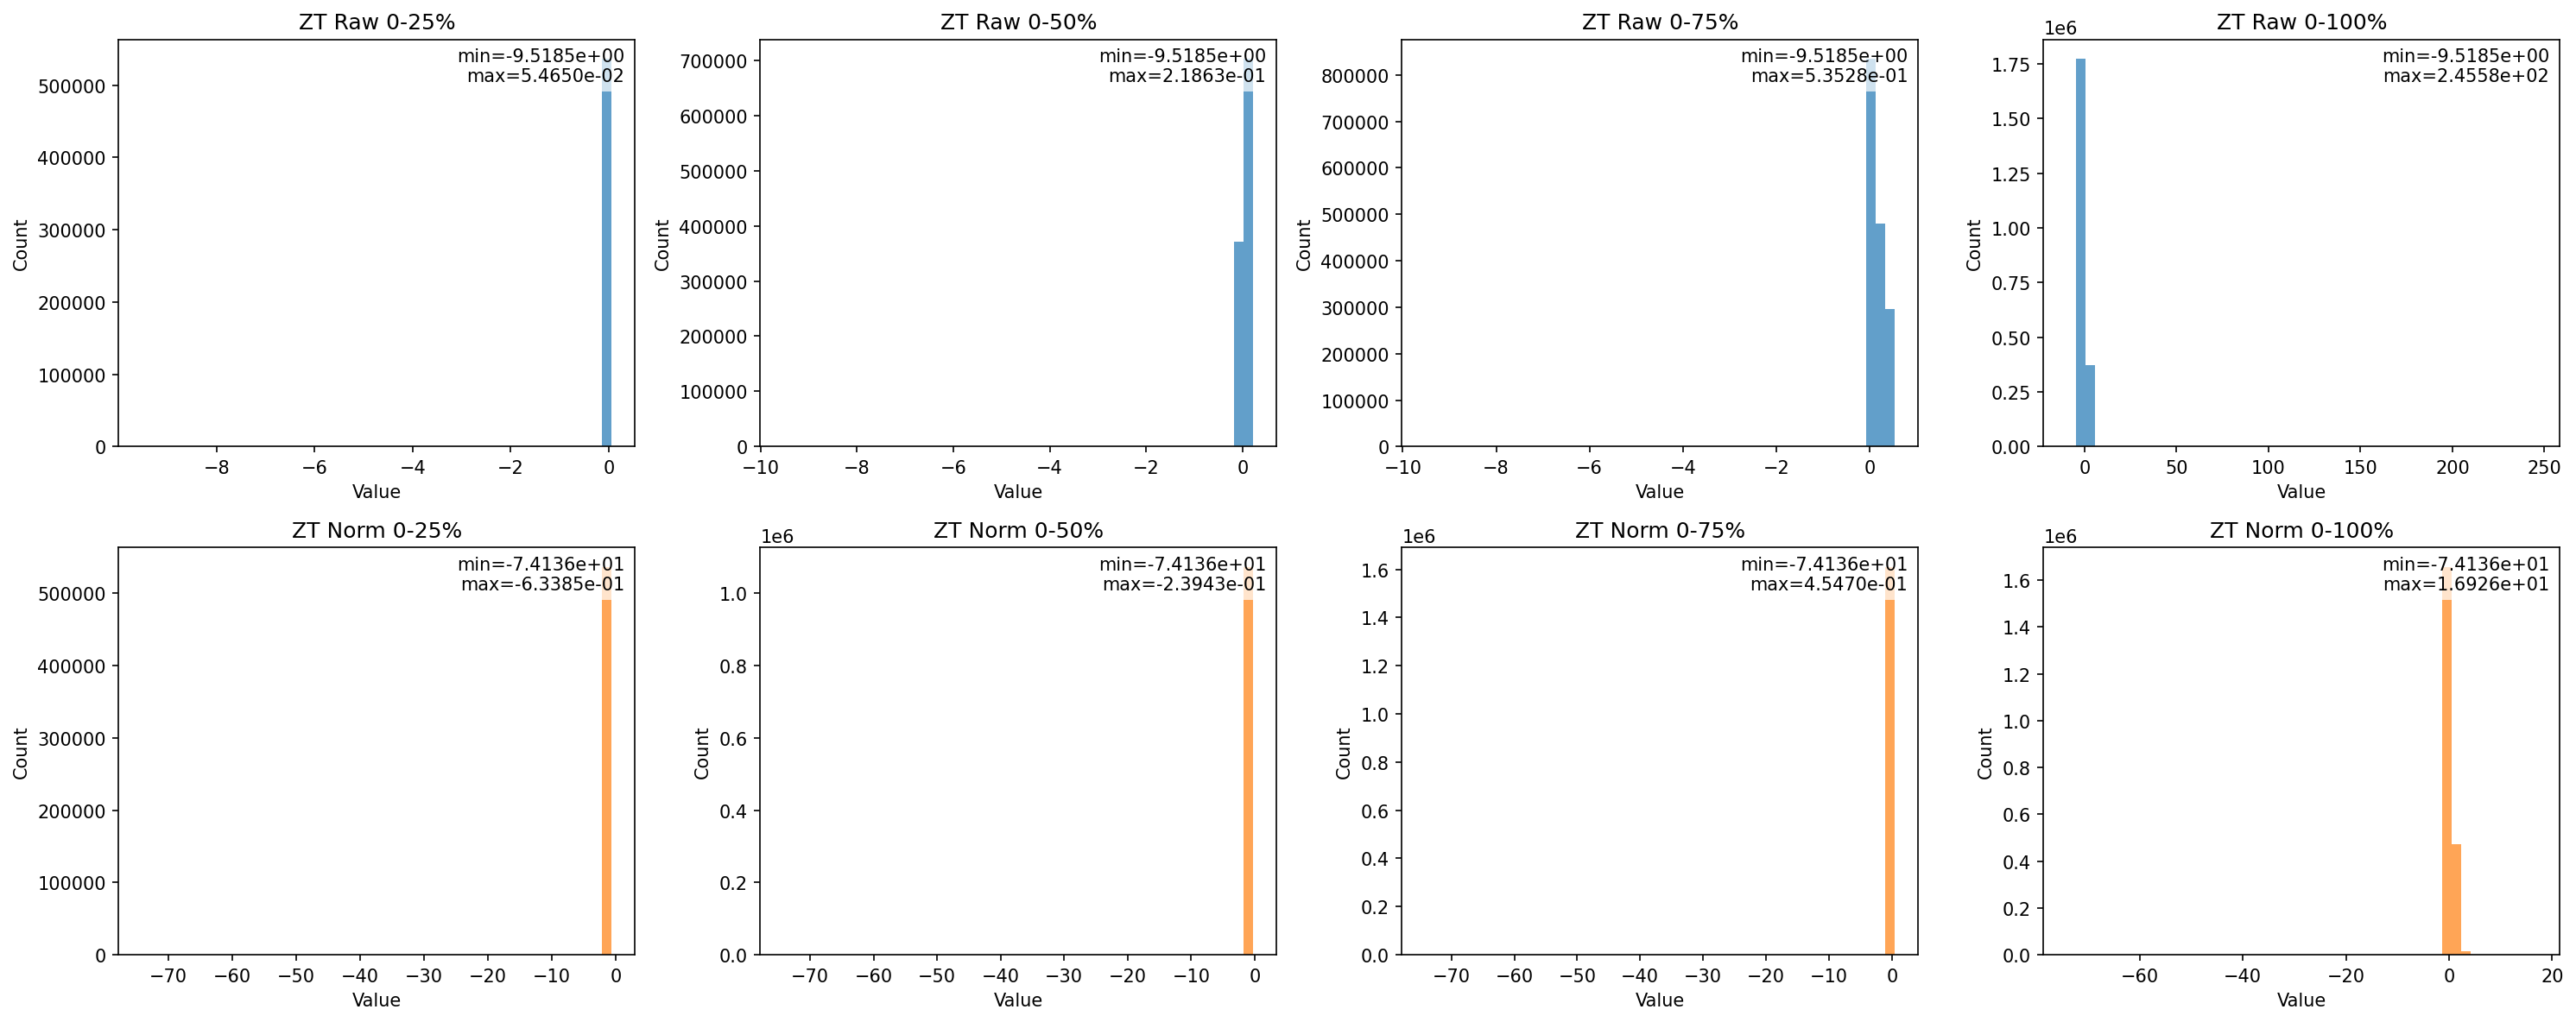

In [12]:
fig, axes = plt.subplots(2, 4, figsize=(20, 8), dpi=150)
percentiles = [0.25, 0.5, 0.75, 1.0]
titles = ["0-25%", "0-50%", "0-75%", "0-100%"]

for row, data_series in enumerate([prop_value, prop_value_norm]):
    a = np.concatenate([i for i in data_series])
    a_sorted = np.sort(a)
    n = len(a_sorted)
    for col, p in enumerate(percentiles):
        end = int(n * p)
        data_slice = a_sorted[:end]
        ax = axes[row, col]
        _ = ax.hist(data_slice, bins=50, color="C0" if row == 0 else "C1", alpha=0.7)
        min_val, max_val = data_slice.min(), data_slice.max()
        _ = ax.set_title(f"{prop} {'Raw' if row == 0 else 'Norm'} {titles[col]}")
        _ = ax.text(
            0.98,
            0.98,
            f"min={min_val:.4e}\nmax={max_val:.4e}",
            ha="right",
            va="top",
            transform=ax.transAxes,
            fontsize=10,
            bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
        )
        _ = ax.set_xlabel("Value")
        _ = ax.set_ylabel("Count")
plt.tight_layout()
plt.show()

Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name       | Type      | Params | Mode 
-------------------------------------------------
0 | d_proj     | Linear    | 37.2 K | train
1 | t_proj     | Linear    | 256    | train
2 | gru        | GRU       | 1.7 M  | train
3 | layer_norm | LayerNorm | 512    | train
4 | decoder    | Linear    | 257    | train
-------------------------------------------------
1.7 M     Trainable params
0         Non-trainable params
1.7 M     Total params
6.875     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/data/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


/data/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.
/data/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (79) is smaller than the logging interval Trainer(log_every_n_steps=100). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 9: 100%|██████████| 79/79 [00:02<00:00, 35.01it/s, v_num=76, train/loss_step=0.0206, val/loss=2.600, train/loss_epoch=19.40]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 79/79 [00:02<00:00, 34.23it/s, v_num=76, train/loss_step=0.0206, val/loss=2.600, train/loss_epoch=19.40]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/data/foundation_model/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=127` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 18/18 [00:00<00:00, 104.34it/s]
plot_prediction_pairs indices: [228, 51, 563, 501, 457, 285, 209, 178, 864]


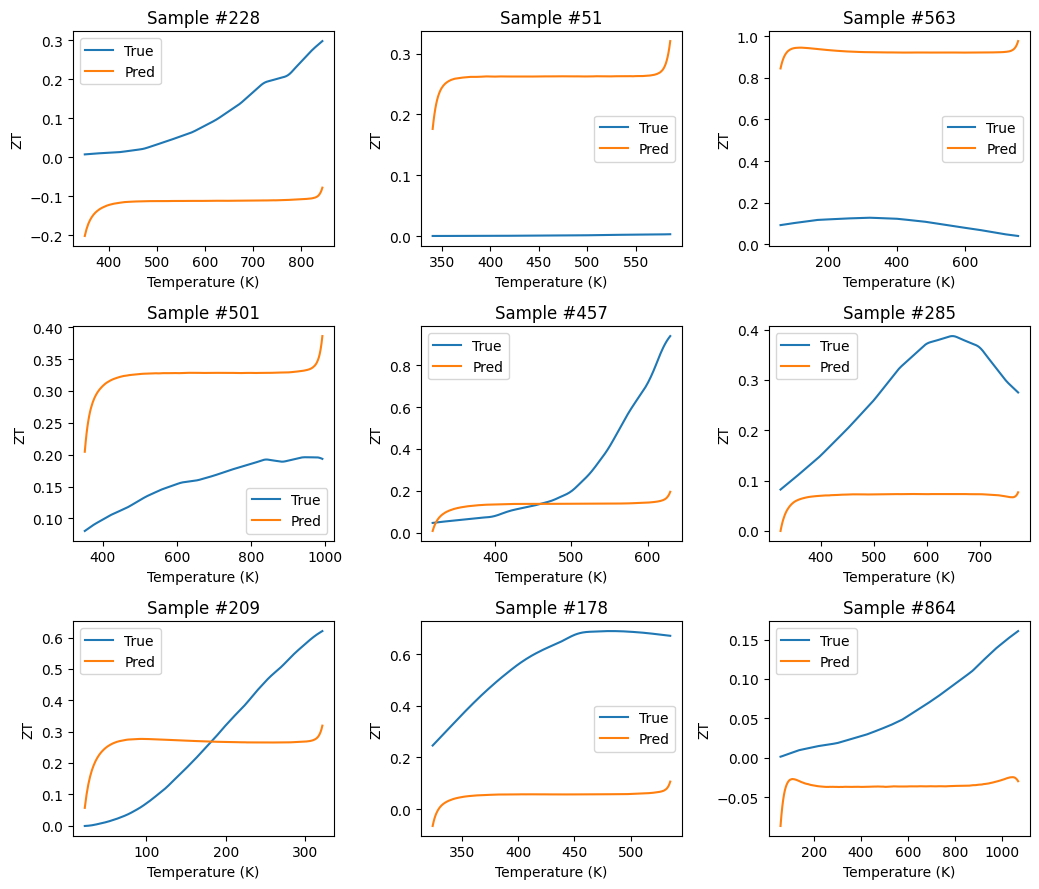

In [14]:
from lightning import Trainer
from lightning.pytorch.callbacks import EarlyStopping

# 1. 初始化数据模块
dm = DOSDataModule(
    desc=desc,
    dos_energy=prop_T,
    dos=prop_value,
    serial=split,
    batch_size=64,
    random_seed=42,
)
dm.setup()

# 2. 初始化模型
model = LightningCurveRNN(
    d_descriptor=desc.shape[1],
    hidden_size=128,
    n_layers=6,
    bidirectional=True,
    use_layer_norm=True,
    lr=1e-5,
    weighted_loss=True,
    weight_ratio=0.5,
    inject_descriptor=True,
    use_mixture_decoder=False,
    n_mixture_components=2,
    use_residual=False,
)

# 3. 初始化训练器
trainer = Trainer(
    max_epochs=10,
    accelerator="auto",
    callbacks=[EarlyStopping(monitor="val/loss", patience=5, mode="min")],
    log_every_n_steps=100,
)

# 4. 开始训练
trainer.fit(model, datamodule=dm)

# 5. predict
preds = trainer.predict(model, dataloaders=dm.test_dataloader())

# 6. 可视化预测结果
# flatten and pass to plot
samples = [sample for batch in preds for sample in zip(*batch)]
plot_prediction_pairs(samples, n=9, prop=prop)